<a href="https://colab.research.google.com/github/gantir/eva4/blob/develop/s9/s9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [1]:
# Manually unpgrading albumentations so the issue with ContextVersion not found when installing evalib is removed.
!pip uninstall albumentations -y
!pip uninstall imgaug -y
!pip install albumentations --upgrade

Uninstalling albumentations-0.4.5:
  Successfully uninstalled albumentations-0.4.5
Uninstalling imgaug-0.2.6:
  Successfully uninstalled imgaug-0.2.6
Processing /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3/albumentations-0.4.5-cp36-none-any.whl
Processing /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0/imgaug-0.2.6-cp36-none-any.whl


In [2]:
!pip install git+https://github.com/gantir/evalib.git@develop

  Cloning https://github.com/gantir/evalib.git (to revision develop) to /tmp/pip-req-build-n1hp0u2u
  Running command git clone -q https://github.com/gantir/evalib.git /tmp/pip-req-build-n1hp0u2u
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Created wheel for evalib: filename=evalib-0.0.post0.dev30+g4513875-py2.py3-none-any.whl size=13686 sha256=c28cbcfc35b4a762f1013570a975e6ed6a2d0bbe26932474e702f7b55e566de5
  Stored in directory: /tmp/pip-ephem-wheel-cache-j48omgwe/wheels/f6/38/b2/08942c9ce5bbe47f487156274e09033e4abe51a7acad6a6d66
Successfully built evalib


In [5]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive/')
except:
  print('May be not using Google Colab')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
from __future__ import print_function
import sys
from argparse import Namespace

import torch
import torchvision
from torchvision import  transforms
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from matplotlib.pyplot import imshow

In [0]:
import evalib
from evalib.gradcam.gradcam import GradCAM, GradCAMpp
from evalib.gradcam.utils import visualize_cam


In [0]:
def configure_optimizers(params, conf):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params, lr=conf.lr, momentum=0.9, weight_decay=conf.l2_decay)
  scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
  return criterion, optimizer, scheduler

In [0]:
config = Namespace(
    batch_size = 64,
    batch_size_cuda = 64,
    num_workers = 4,
    SEED = 170,
    EPOCHS = 1,
    dropout = 0.0,
    lr = 1e-3,
    l1_decay =  0,
    l2_decay = 1e-4   
)
evalib.utils.init_seed(config.SEED)

In [10]:
data = evalib.data.cifar.CIFAR(config)

Extracting ./data/cifar-10-python.tar.gz to ./data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   dog truck  bird


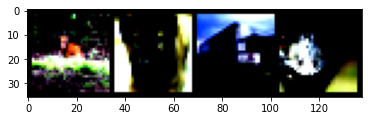

In [11]:
data_iter = iter(data.test_loader)
images, labels = data_iter.next()
index_start, index_end = 32,36
evalib.plot.imshow_torch(torchvision.utils.make_grid(images[index_start:index_end]))
print(' '.join('%5s' % data.classes[label] for label in labels[index_start:index_end]))

# imshow(transforms.ToPILImage()(images[32]))

In [12]:
net = evalib.models.resnet.ResNet18(config.dropout)
model = net.to(evalib.utils.get_device())
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
criterion, optimizer, scheduler = configure_optimizers(model.parameters(), config)

In [14]:
[(train_acc, train_loss), (val_acc, val_loss)] = evalib.tnt.train_n_test(model, criterion, optimizer, scheduler, data.train_loader, data.test_loader, num_epochs=config.EPOCHS)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1


Batch Id/Size: 782/50000, Training Loss: 2.17227077, Training Accuracy: 45.1500%: 100%|██████████| 782/782 [01:01<00:00, 12.68it/s]
  0%|          | 0/157 [00:00<?, ?it/s]

LR: [0.001]


100%|██████████| 157/157 [00:03<00:00, 52.28it/s]


Batch Id/Size: 157/10000, Test Loss: 0.01813998, Test Accuracy: 58.8800%



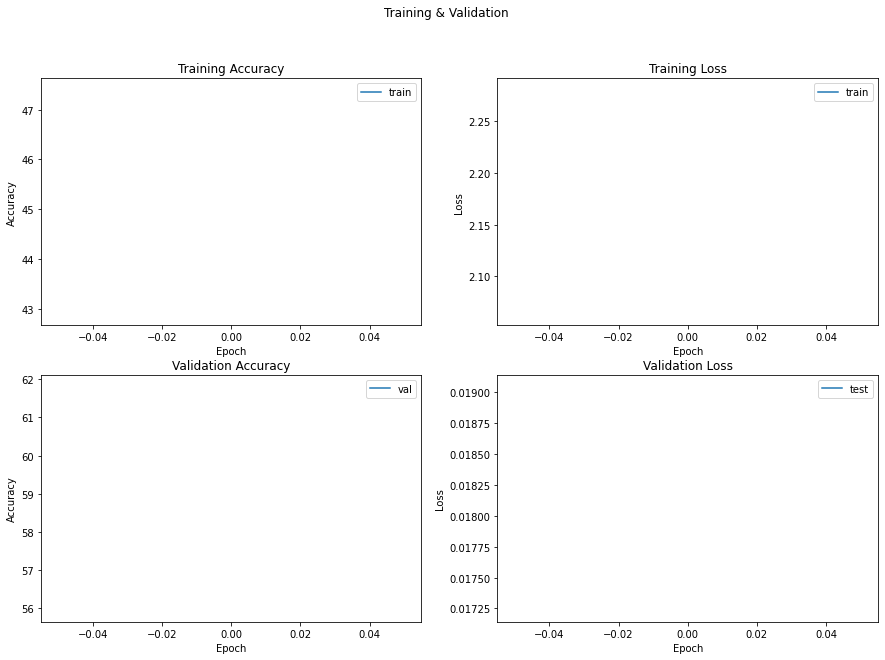

In [15]:
evalib.plot.plot_acc_loss(
    {'train': train_acc},
    {'val': val_acc},
    {'train': train_loss},
    {'test': val_loss}
)

In [0]:
def get_wrong_correct_predictions(model,data_loader, count=10):
  device = evalib.utils.get_device()
  data_iter = iter(data.test_loader)
  wrong_classification = []
  correct_classification = []

  for images, labels in data_iter:
    images, labels = images.to(device), labels.to(device)
    
    output = model(images)
    _, pred = output.max(1)
    is_correct = (pred == labels)
    
    wrong_classification_index = (is_correct==0).nonzero().cpu().numpy()[:,0]
    for idx in wrong_classification_index:
      if count <= len(wrong_classification):
        break
      wrong_classification.append({
        "target": labels[idx].cpu().numpy(),
        "pred": pred[idx].cpu().numpy(),
        "img": images[idx].cpu()
      })
    
    correct_classification_index = (is_correct==1).nonzero().cpu().numpy()[:,0]
    for idx in correct_classification_index:
      if count <= len(correct_classification):
        break
      correct_classification.append({
        "target": labels[idx].cpu().numpy(),
        "pred": pred[idx].cpu().numpy(),
        "img": images[idx].cpu()
      })
      
    
    if count <= len(correct_classification) and count <= len(wrong_classification):
      break
  
  return correct_classification, wrong_classification


In [0]:
c,w = get_wrong_correct_predictions(model, data.test_loader,count=25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

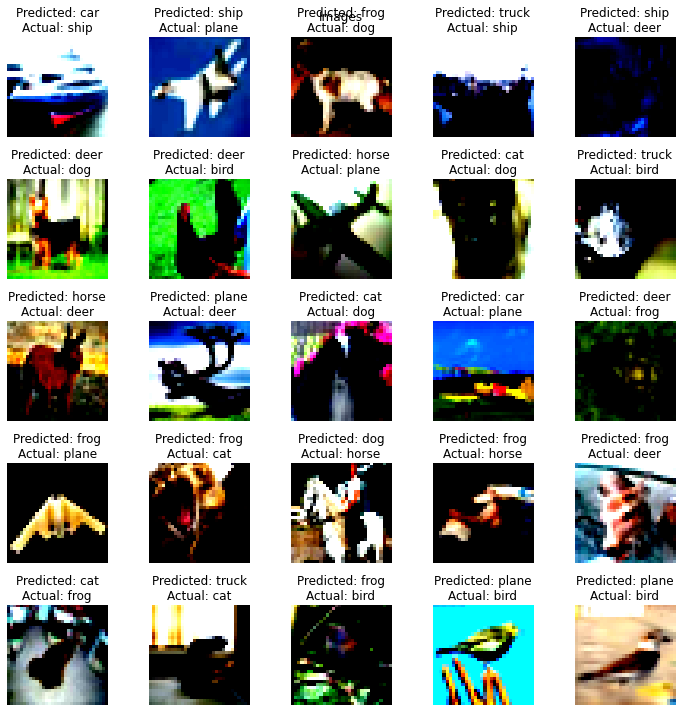

In [19]:
evalib.plot.plot_images(w, data.classes, "correct_imgs.png")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

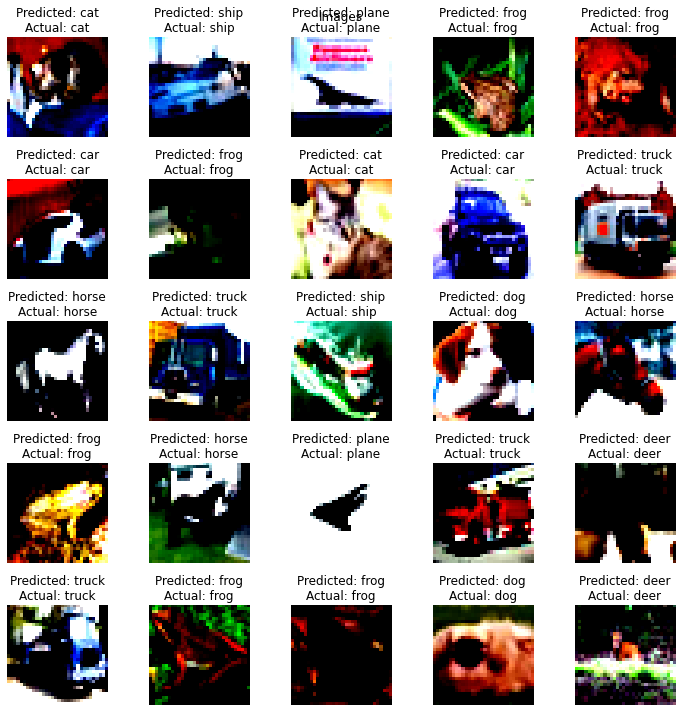

In [20]:
evalib.plot.plot_images(c, data.classes, "correct_imgs.png")


In [0]:
# Grad Cam
configs = [
    dict(model_type='resnet', arch=model, layer_name='layer1'),
    dict(model_type='resnet', arch=model, layer_name='layer2'),
    dict(model_type='resnet', arch=model, layer_name='layer3'),
    dict(model_type='resnet', arch=model, layer_name='layer4'),
]

for config in configs:
    config['arch'].to(evalib.utils.get_device()).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

In [43]:


# img_dir = 'images'
# img_name = 'collies.JPG'
# img_name = 'multiple_dogs.jpg'
# img_name = 'snake.JPEG'
# img_name = 'water-bird.JPEG'
# img_path = os.path.join(img_dir, img_name)
# import PIL
# pil_img = PIL.Image.open(w[0]['img'].numpy())
# pil_img

# torch_img = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])(pil_img).to(device)
torch_images = [i['img'].to(evalib.utils.get_device()) for i in w]
# torch_img = w[0]['img']
# normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
# normed_torch_img = data.test_loader.dataset
# plt.imshow(np.transpose(normed_torch_img.numpy(), (1,2,0)))
# transforms.ToPILImage()(normed_torch_img)
print(torch_images[0])

tensor([[[ 1.7416,  1.6781,  1.6939,  ...,  1.7098,  1.7098,  1.6939],
         [ 1.7892,  1.7416,  1.7416,  ...,  1.7575,  1.7575,  1.7416],
         [ 1.7733,  1.7257,  1.7257,  ...,  1.7416,  1.7416,  1.7257],
         ...,
         [-0.6082, -1.3068, -1.6878,  ...,  0.6937,  0.9001,  0.9954],
         [-0.6876, -1.2591, -1.4179,  ...,  0.7731,  0.9477,  0.9795],
         [-0.6399, -1.0051, -1.0686,  ...,  0.6778,  0.8683,  0.9636]],

        [[ 1.8081,  1.7435,  1.7597,  ...,  1.7758,  1.7758,  1.7597],
         [ 1.8565,  1.8081,  1.8081,  ...,  1.8242,  1.8242,  1.8081],
         [ 1.8404,  1.7920,  1.7920,  ...,  1.8081,  1.8081,  1.7920],
         ...,
         [-0.3867, -1.1613, -1.6132,  ...,  0.9851,  1.1949,  1.2755],
         [-0.4351, -1.0645, -1.2743,  ...,  1.0657,  1.2433,  1.2755],
         [-0.3544, -0.7740, -0.9031,  ...,  0.9689,  1.1626,  1.2433]],

        [[ 1.8202,  1.7601,  1.7751,  ...,  1.7901,  1.7901,  1.7751],
         [ 1.8653,  1.8202,  1.8202,  ...,  1

In [1]:
for torch_img in torch_images:
  images = []
  normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
  print(torch_img)
  print(normed_torch_img)
  exit()
  for gradcam, gradcam_pp in cams:
      mask, _ = gradcam(normed_torch_img)
      heatmap, result = visualize_cam(mask, torch_img)

      mask_pp, _ = gradcam_pp(normed_torch_img)
      heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
      
      images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
  grid_image = torchvision.utils.make_grid(images, nrow=5)
  # print(grid_image)
  
torchvision.transforms.ToPILImage()(grid_image)

# print(images) 


NameError: ignored